## Object Detection with FasterRCNN

Import libraries

In [1]:

import numpy as np 
import pandas as pd 
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from PIL import Image
import matplotlib.pyplot as plt

import matplotlib.patches as patches
import os


import numba
import re
import cv2
import ast
import matplotlib.pyplot as plt

from numba import jit
from typing import List, Union, Tuple


Install pycoco tools to use the COCO format annotations

In [2]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' -q

from pycocotools.coco import COCO

In [3]:
#reading the annoattion file
coco = COCO('data/trainval/annotations/bbox-annotations.json')

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


In [4]:
#generate target
def generate_target(img_ids):
    """Generate the target dictionary for each image_id.

    Args:
        img_ids: (int) image_id number of the whole dataset
        
    Returns:
        (str) filename : 'image001.png'
        (dict) target :{'boxes':[[xmin,ymin,xmax,ymax],.....],'labels':[0,...],'image_id','1'}
    """
    #get the annotations for each image_ids
    annotation_ids = coco.getAnnIds(img_ids)
    annotations = coco.loadAnns(annotation_ids)
    image_meta = coco.loadImgs(annotations[0]["image_id"])[0]
    boxes=[]
    labels=[]
    for ann in annotations:
        x,y,w,h = ann['bbox']
        if w!=0  and h!=0:
            bbox = [x,y,x+w,y+h]
            boxes.append(bbox)
            labels.append(ann['category_id'])
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    img_id = torch.tensor([img_ids])
    target = {}
    target["boxes"] = boxes    
    target["labels"] = labels
    target["image_id"] = img_id
    return image_meta["file_name"], target

In [5]:
# Dataset class for Training - 90%of data
class CustomDataset_Train(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files
        self.img_ids = range(0, int(0.9*len(os.listdir('data/trainval/images/'))))
    def __getitem__(self, idx):
        """Gives the image and target for each image id

        Args:
            idx: (int) image_id
        Returns:
            (torch.tensor) image of shape (c,h,w)
            (dict) target :{'boxes':[[xmin,ymin,xmax,ymax],.....],'labels':[1,2,1,...],'image_id','1'}
        """
        image_name, target = generate_target(idx)
        img_path = os.path.join("data/trainval/images/", image_name)
        img = Image.open(img_path).convert("RGB")
        
        if self.transforms is not None:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.img_ids)
    
#preprocessing transformation      
data_transform = transforms.Compose([
        transforms.ToTensor(), ])
#batch processing
def collate_fn(batch):
    return tuple(zip(*batch))

# Train Dataset loader for pytorch model
train_dataset = CustomDataset_Train(data_transform)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)

In [6]:
# Dataset class for Validation - 10%of data
class CustomDataset_Val(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files
        self.img_ids = range(int(0.9*len(os.listdir('data/trainval/images/'))), 
                             len(os.listdir('data/trainval/images/')))
    def __getitem__(self, idx):
        image_name, target = generate_target(idx)
        img_path = os.path.join("data/trainval/images/", image_name)
        img = Image.open(img_path).convert("RGB")
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.img_ids)

# Test Dataset loader for pytorch model
test_dataset = CustomDataset_Val(data_transform)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

In [7]:
# for FasterRCNN with FPN model
def get_model(num_classes):
    """ Creates the model for training

    Args:
        num_classes: (int) Number of classes in the dataset
       
    Returns:
        (model) pytorch model
    """
    # load an model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


model = get_model(3)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [8]:
#devic info (GPU/CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#Training code

num_epochs = 100
model.to(device)   

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(train_data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in train_data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    torch.save(model.state_dict(),'fasterrcnn_resnet50_fpn_100epochs.pth')
    print('Epoch '+str(epoch)+'----> loss: ',epoch_loss)

In [9]:
#Load the trained model
model.load_state_dict(torch.load('trained-frcnn-fpn-model/fasterrcnn_resnet50_fpn_100epochs.pth'))

<All keys matched successfully>

In [10]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [11]:

def plot_image(img_tensor, annotation, groudtruth):
    """Plots the groundtruth and prediction.

    Args:
        img_tensor: (tensor) original image
        annotation: (dict) {'boxes':[[....]],'labels':[1,2,1...],'scores':[0.8,0.99,011....]} prediction from the model
        groundtruth: (dict) {'boxes':[[....]],'labels':[1,2,1...],'scores':[0.8,0.99,011....]} groudtruth annotations
    Returns:
        (ax) plot with image and bounding boxes of both prediction and groundtruth
    """
    fig,(ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
    img = img_tensor.cpu().data

    # Display the image
    ax1.imshow(img.permute(1, 2, 0))
    
    for box, label, score in zip(annotation["boxes"],annotation['labels'],annotation['scores'] ):
        if score>0.5:
            xmin, ymin, xmax, ymax = box
            if label.cpu()==1:
                color='r'
            else:
                color='b'

            # Create a Rectangle patch
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=color,facecolor='none')

            # Add the patch to the Axes
            ax1.add_patch(rect)
    ax1.set_title('Prediction')
        # Display the image
    ax2.imshow(img.permute(1, 2, 0))
    
    for box, label in zip(groudtruth["boxes"],groudtruth['labels']):
        xmin, ymin, xmax, ymax = box
        if label.cpu()==1:
            color='r'
        else:
            color='b'

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=color,facecolor='none')

        # Add the patch to the Axes
        ax2.add_patch(rect)
    ax2.set_title('Groudtruth')
    plt.show()

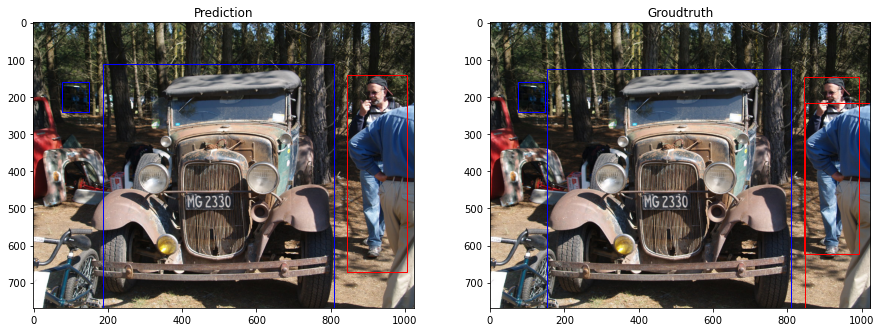

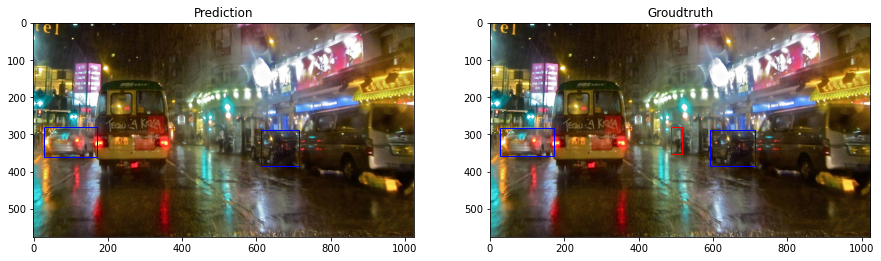

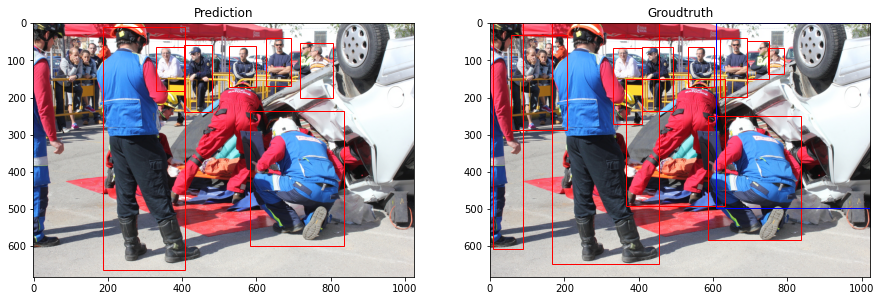

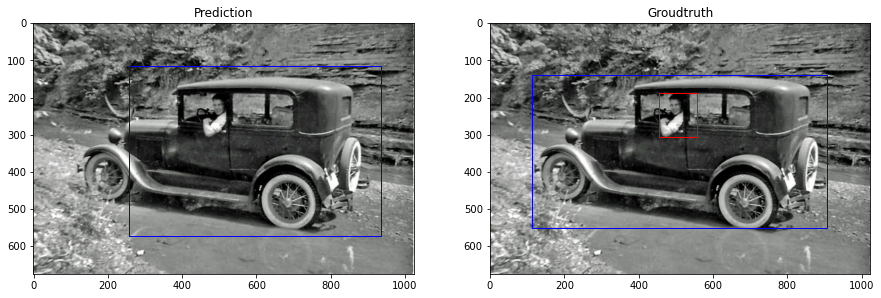

In [12]:
#Visulaize few predictions
for imgs, annotations in test_data_loader:
    imgs = list(img.to(device) for img in imgs)
    model.eval()
    preds = model(imgs)
    for i in range(len(preds)):
#         print(annotations[i]['labels'], preds[i]['labels'])
        plot_image(imgs[i], preds[i], annotations[i])
    break

Perforamnce metrics

In [13]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [14]:
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx


def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [15]:
#Find the classwise Mean precisions of the boxes predicted for different iou thresholds

iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
MAP, MAP_class1, MAP_class2=[], [],[]
for imgs, annotations in test_data_loader:
    imgs = list(img.to(device) for img in imgs)
    model.eval()
    preds = model(imgs)
    for i in range(len(annotations)):
        gt_boxes= annotations[i]['boxes'].cpu().numpy()
        gt_labels = annotations[i]['labels'].cpu().detach().numpy()
        pred_boxes= preds[i]['boxes'].cpu().detach().numpy()
        scores = preds[i]['scores'].cpu().detach().numpy()
        pr_labels = preds[i]['labels'].cpu().detach().numpy()
#         print(gt_labels, pr_labels)
        preds_sorted = np.argsort(scores)[::-1]
        preds_sorted = pred_boxes[preds_sorted]
        MAP.append(calculate_image_precision(preds_sorted,gt_boxes,
                                                    thresholds=iou_thresholds,form='pascal_voc'))
        #class 1 MAP calculation
        index_class1 = np.where(pr_labels==1)[0]
        scores_class1 = scores[index_class1]
        pred_boxes_class1 = preds_sorted[index_class1]
        preds_sorted = np.argsort(scores_class1)[::-1]
        preds_sorted = pred_boxes_class1[preds_sorted]
        index_class1 = np.where(gt_labels==1)[0]
        gt_boxes_class1 = gt_boxes[index_class1]
        
        MAP_class1.append(calculate_image_precision(preds_sorted,gt_boxes_class1,
                                                    thresholds=iou_thresholds,form='pascal_voc'))
        
        #class 2 MAP calculation
        index_class2 = np.where(pr_labels==2)[0]
        scores_class2 = scores[index_class2]
        pred_boxes_class2 = pred_boxes[index_class2]
        preds_sorted = np.argsort(scores_class2)[::-1]
        preds_sorted = pred_boxes_class2[preds_sorted]
        index_class2 = np.where(gt_labels==2)[0]
        gt_boxes_class2 = gt_boxes[index_class2]
        
        MAP_class2.append(calculate_image_precision(preds_sorted,gt_boxes_class2,
                                                    thresholds=iou_thresholds,form='pascal_voc'))

print('Average image precision: ', np.mean(MAP)) 
print({1: np.mean(MAP_class1), 2: np.mean(MAP_class2)})

Average image precision:  0.42993419826134666
{1: 0.46230681697771076, 2: 0.4560799916678987}


---